Libaries Importation

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
%matplotlib inline
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
import os
warnings.filterwarnings("ignore")

import pickle

# Data Loading

In [8]:
train = pd.read_csv('D://projects data science//ETA-UBER//Train.csv')

test = pd.read_csv('D://projects data science//ETA-UBER//Test.csv')


sample = pd.read_csv('D://projects data science//ETA-UBER//SampleSubmission.csv')
weather = pd.read_csv('D://projects data science//ETA-UBER//Weather.csv')

# Dataset Overview

In [9]:
train.head(2)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
0,000FLWA8,2019-12-04T20:01:50Z,3.258,36.777,3.003,36.718,39627,2784
1,000RGOAM,2019-12-10T22:37:09Z,3.087,36.707,3.081,36.727,3918,576


In [10]:
test.head(2)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
0,000V4BQX,2019-12-21T05:52:37Z,2.981,36.688,2.978,36.754,17549
1,003WBC5J,2019-12-25T21:38:53Z,3.032,36.769,3.074,36.751,7532


In [11]:
 #create a copy of test for submissions later
test_copy = test.copy()


sort the train set by date (timestamp)


In [12]:
 # make sure sorted by date
train = train.sort_values('Timestamp')

Split the datetime column into date and time components in both the train and test DataFrames.


In [13]:
# split datetime column into date and time
def split_datetime_column(df, date):
 df['time'] = df[date].str[10:]
 df['date'] = df[date].str[:10]
 df.drop(columns=['Timestamp', 'ID'], inplace = True, axis=1)
 return df
train = split_datetime_column(train, 'Timestamp')
test = split_datetime_column(test, 'Timestamp')


Convert Time to Seconds


In [14]:

def time_to_secs(df):
 # Extract hours, minutes, and seconds using vectorized operations
 time_parts = df['time'].str[1:-1].str.split(':', expand=True).astype(int)
 hours, minutes, seconds = time_parts[0], time_parts[1], time_parts[2]
 df.drop(columns=['time'], inplace = True, axis=1)
 # Convert time to total seconds since midnight
 df['total_secs'] = hours * 3600 + minutes * 60 + seconds
time_to_secs(train)
time_to_secs(test)


set date as index for train and test set


In [15]:
test.set_index('date', inplace= True)
train.set_index('date', inplace= True)

In [16]:
train.head(2)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,total_secs
date,,,,,,,
2019-11-19,3.021,36.751,3.031,36.769,3898,556,82808
2019-11-19,2.972,36.760,3.006,36.728,5861,785,82810


In [17]:
test.head(2)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,total_secs
date,,,,,,
2019-12-21,2.981,36.688,2.978,36.754,17549,21157
2019-12-25,3.032,36.769,3.074,36.751,7532,77933


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35625 entries, 2019-12-21 to 2019-12-20
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Origin_lat       35625 non-null  float64
 1   Origin_lon       35625 non-null  float64
 2   Destination_lat  35625 non-null  float64
 3   Destination_lon  35625 non-null  float64
 4   Trip_distance    35625 non-null  int64  
 5   total_secs       35625 non-null  int32  
dtypes: float64(4), int32(1), int64(1)
memory usage: 1.8+ MB


In [19]:
weather.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


In [20]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        61 non-null     object 
 1   dewpoint_2m_temperature     61 non-null     float64
 2   maximum_2m_air_temperature  61 non-null     float64
 3   mean_2m_air_temperature     61 non-null     float64
 4   mean_sea_level_pressure     61 non-null     float64
 5   minimum_2m_air_temperature  61 non-null     float64
 6   surface_pressure            61 non-null     float64
 7   total_precipitation         61 non-null     float64
 8   u_component_of_wind_10m     61 non-null     float64
 9   v_component_of_wind_10m     61 non-null     float64
dtypes: float64(9), object(1)
memory usage: 4.9+ KB


In [21]:
train.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,total_secs
count,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000
mean,3.052406,36.739358,3.056962,36.737732,13527.821410,1111.697762,56882.935787
std,0.096388,0.032074,0.100710,0.032781,9296.716006,563.565486,31568.908654
min,2.807000,36.589000,2.807000,36.596000,1.000000,1.000000,0.000000
25%,2.994000,36.721000,2.995000,36.718000,6108.000000,701.000000,19450.000000
50%,3.046000,36.742000,3.049000,36.742000,11731.500000,1054.000000,74784.000000
75%,3.095000,36.760000,3.109000,36.760000,19369.000000,1456.000000,79617.000000
max,3.381000,36.820000,3.381000,36.819000,62028.000000,5238.000000,86398.000000


# Hypothesis


H0: eta is mostly determined by trip distance


H1: eta is not mostly determined by trip distance

# Questions

1. Is the train data complete?
2. Do we have seasonality in ETA?
3. What is the distribution of ETA?
4. What is the distribution of trip distances?
5. How does ETA vary over time? Is there a trend?

# Data Cleaning

Here, we will prepare our data for Univariate and Bivariate analysis

# Fixing our Issues and merge our Data

In [22]:
#merging train and test with weather dataset

def merge(df1,df2):
    merged_df= df1.merge(df2, how='left', on='date')
    
    return merged_df


In [23]:
# Merge the weather data into the training and testing data
train = merge(train.reset_index(), weather)
test = merge(test.reset_index(), weather)
# Set the date as the index
train.set_index('date', inplace= True)
test.set_index('date', inplace= True)


# Drop Duplicates


train.drop_duplicates(inplace=True)

# Impute Missing Values


In [24]:
print(train.isnull().sum())
print(test.isnull().sum())

Origin_lat                    0
Origin_lon                    0
Destination_lat               0
Destination_lon               0
Trip_distance                 0
ETA                           0
total_secs                    0
dewpoint_2m_temperature       0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m       0
dtype: int64
Origin_lat                    0
Origin_lon                    0
Destination_lat               0
Destination_lon               0
Trip_distance                 0
total_secs                    0
dewpoint_2m_temperature       0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m    

# Exploratory Data Analysis: EDA


# Hypothesis Validation


H0: eta is mostly determined by trip distance


H1: eta is not mostly determined by trip distance



We can see from the heatmap below that trip distance has the highest correlation with ETA. This means that
trip distance is the variable that affects ETA the most.

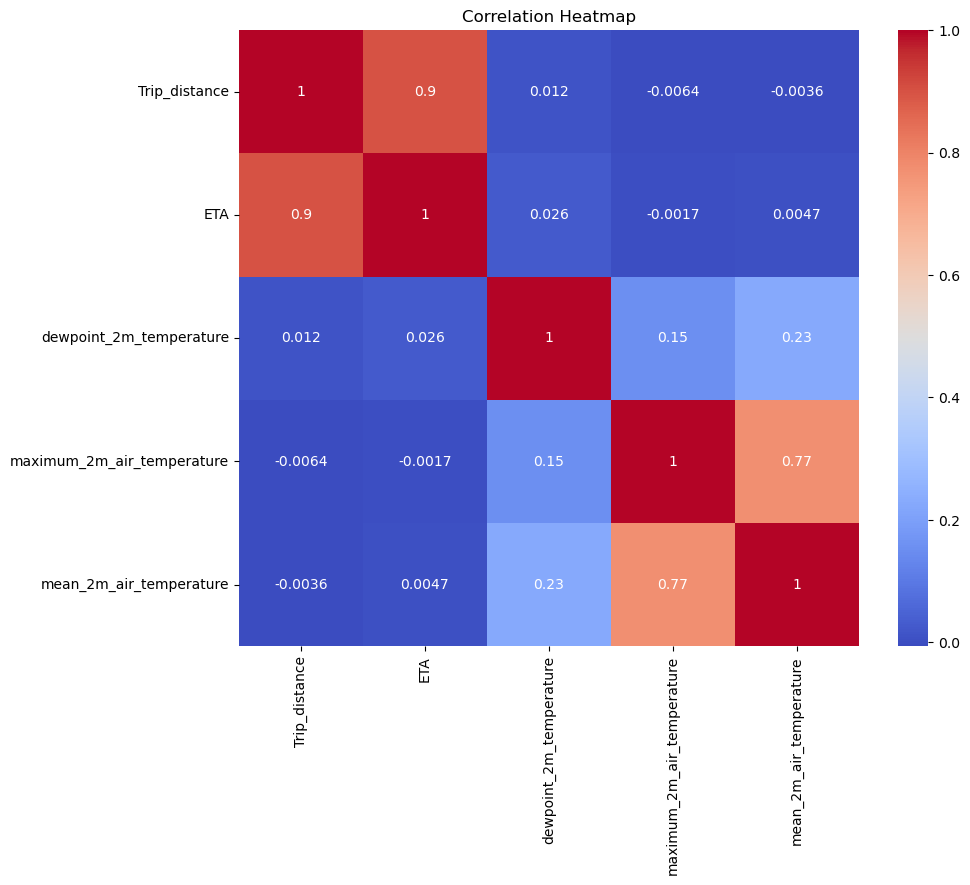

In [25]:
# Correlation Heatmap
correlation_matrix = train[['Trip_distance', 'ETA', 'dewpoint_2m_temperature',
                            'maximum_2m_air_temperature', 'mean_2m_air_temperature']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

We therefore accept our null hypothesis which states that ETA is mostly determined by trip distance.


1. Is the train data complete?


In [26]:
# create a function to check for missing extracted dates
def get_missing_dates(df):
 col = df.index
 missing_dates = (pd.date_range(
 start=col.min(), #start date
 end=col.max()) #end_date
 .difference(col))
 print(f"we have {len(missing_dates)} dates missing out of {len(col)}")
 print(f"start: {col.min()}, end: {col.max()}")
 return missing_dates


In [27]:
get_missing_dates(train)


we have 0 dates missing out of 83924
start: 2019-11-19, end: 2019-12-19


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [28]:
get_missing_dates(test)


we have 0 dates missing out of 35625
start: 2019-12-20, end: 2019-12-31


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

we can see above the the training data is incomplete. So we will fill in the missing dates


In [29]:

def fill_missing_dates(df):
 missing_dates = (pd.DataFrame(
 pd.date_range(
 start=df.index.min(), end=df.index.max())
 .difference(df.index)
 , columns=['date']))
 #add missing df dates
 df = pd.concat([df, missing_dates], ignore_index=True)
 #filling missing df values
 cols = df.columns
 for col in cols:
        df[col] = df[col].ffill().bfill()
 return df
train = fill_missing_dates(train)
test = fill_missing_dates(test)


2. Do we have seasonality in ETA?


In [30]:
# Assuming your time series data is stored in the variable 'eta_data'
eta_data = train['ETA']


In [31]:
# Perform KPSS test
kpss_result = kpss(eta_data)
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_critical_values = kpss_result[3]


In [32]:
print("\nKPSS Test:")
print("KPSS Statistic:", kpss_statistic)
print("p-value:", kpss_pvalue)



KPSS Test:
KPSS Statistic: 0.6306308649261976
p-value: 0.019851739552163856


In [33]:
 # Perform the ADF test
result = adfuller(train['ETA'])

In [34]:
# Extract and print the results
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
# Check the p-value against a significance level (e.g., 0.05) to make a decision about s
if p_value <= 0.05:
 print('The time series is likely stationary.')
else:
 print('The time series is likely non-stationary.')

ADF Statistic: -29.40162172723213
p-value: 0.0
The time series is likely stationary.


In [35]:
train.head()


,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,total_secs,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,date
0,3.021,36.751,3.031,36.769,3898.0,556.0,82808.0,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,NaT
1,2.972,36.760,3.006,36.728,5861.0,785.0,82810.0,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,NaT
2,2.850,36.682,3.048,36.784,26065.0,1661.0,82838.0,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,NaT
3,2.984,36.757,3.005,36.777,4943.0,629.0,82844.0,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,NaT
4,2.861,36.761,3.186,36.721,37492.0,2181.0,82853.0,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,NaT


3. What is the distribution of ETA?


In [36]:
# Distribution of ETA:
print("Mean ETA:", train['ETA'].mean())
print("Median ETA:", train['ETA'].median())
print("Standard Deviation of ETA:", train['ETA'].std())


Mean ETA: 1111.6977622610934
Median ETA: 1054.0
Standard Deviation of ETA: 563.565485516394


4. What is the distribution of trip distances?

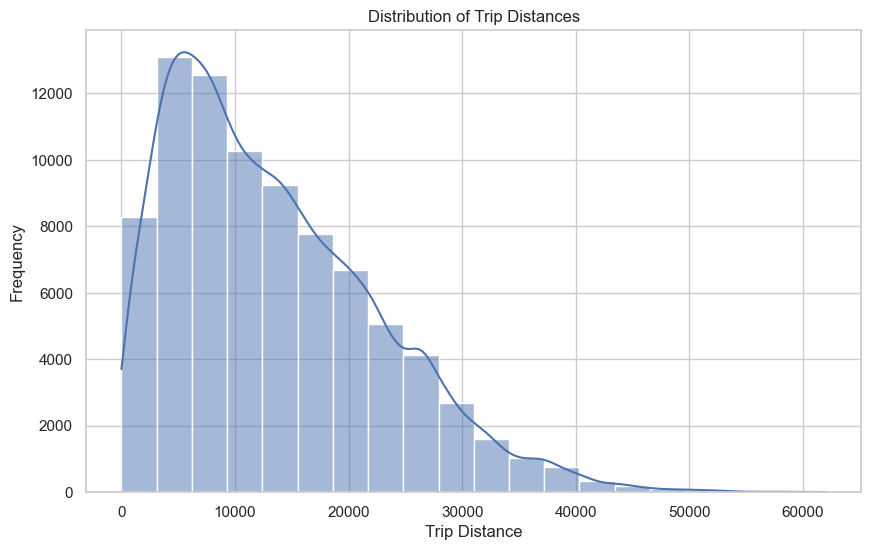

In [37]:
# Set seaborn style
sns.set(style="whitegrid")
# Question 1: Distribution of Trip Distances
plt.figure(figsize=(10, 6))
sns.histplot(train['Trip_distance'], bins=20, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.show()

5. How does ETA vary over time? Is there a trend?


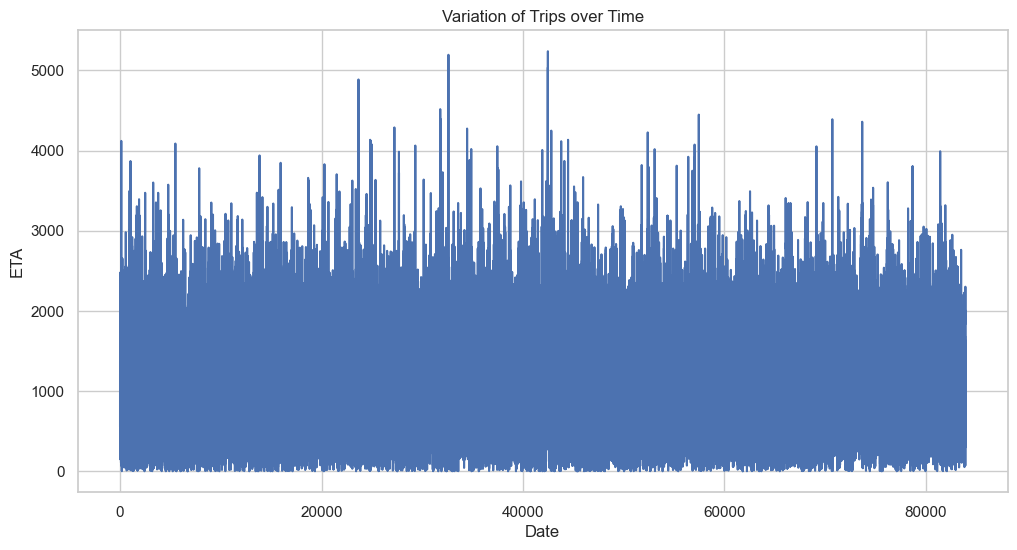

In [38]:
# Question 2: Variation of Trips over Time
plt.figure(figsize=(12, 6))
train['ETA'].plot()
plt.title('Variation of Trips over Time')
plt.xlabel('Date')
plt.ylabel('ETA')
plt.show()

There is no trend in ETA over time.


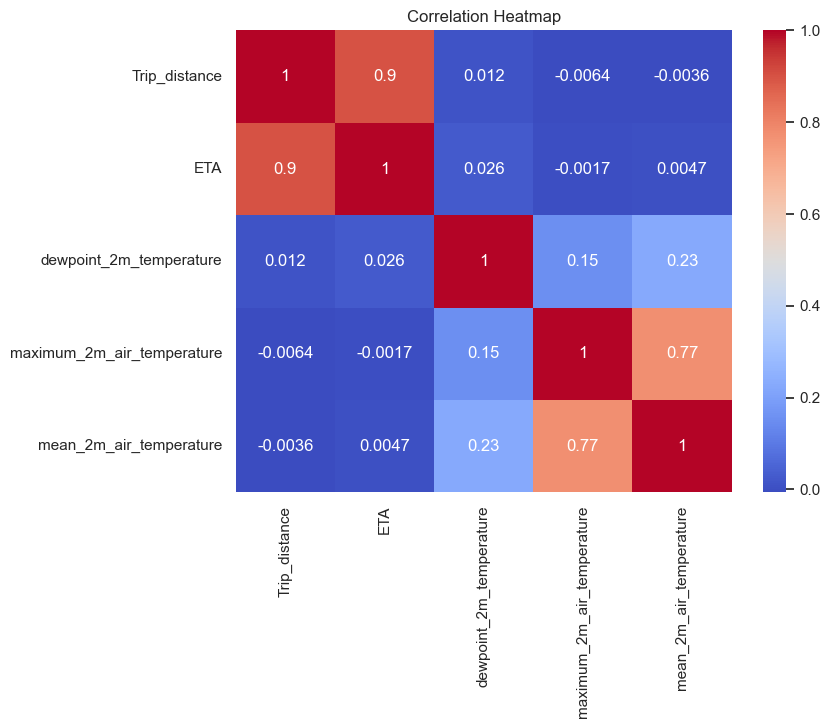

In [39]:

# Question 3: Correlation Heatmap
correlation_matrix = train[['Trip_distance', 'ETA', 'dewpoint_2m_temperature',
                            'maximum_2m_air_temperature', 'mean_2m_air_temperature']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

maximum_2m_air_temperature and mean_2m_air_temperature have a high correlation of 0.77 or 77%


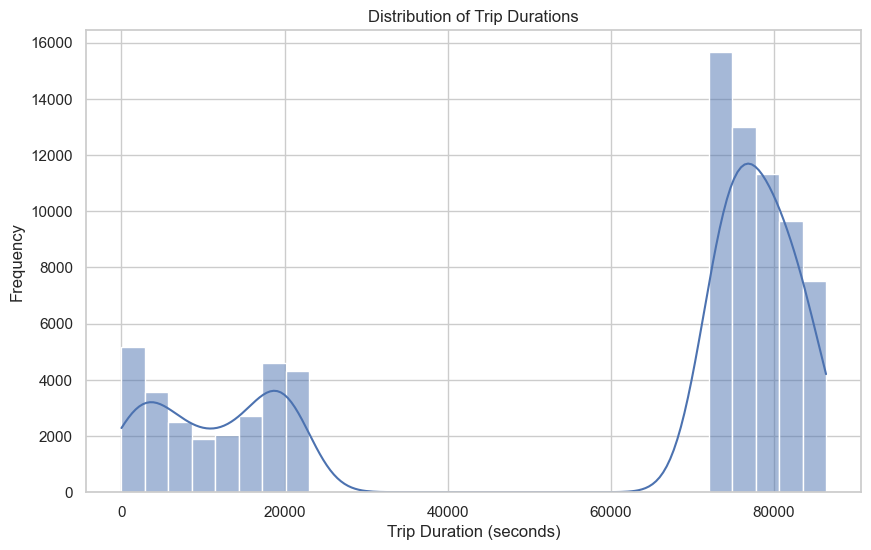

In [40]:
# Question 4: Distribution of Trip Durations
plt.figure(figsize=(10, 6))
sns.histplot(train['total_secs'], bins=30, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Features Encoding & scaling


In [41]:
numeric_columns = train.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
categoric_columns = [col for col in train.columns if col not in numeric_columns]
categoric_columns

['date']

In [42]:
numeric_columns.remove('ETA')
print(numeric_columns)

['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon', 'Trip_distance', 'total_secs', 'dewpoint_2m_temperature', 'maximum_2m_air_temperature', 'mean_2m_air_temperature', 'mean_sea_level_pressure', 'minimum_2m_air_temperature', 'surface_pressure', 'total_precipitation', 'u_component_of_wind_10m', 'v_component_of_wind_10m']


In [43]:
from sklearn.preprocessing import StandardScaler

In [55]:
 #Create an instance of StandardScaler and set output to be a DataFrame
#scaler = StandardScaler().fit(train[numeric_columns]).set_output(transform="pandas")
#num = scaler.transform(train[numeric_columns])
#num_test = scaler.transform(test[numeric_columns])



import pandas as pd

# ... your code to prepare training and test data ...

# Create an instance of StandardScaler
scaler = StandardScaler().fit(train[numeric_columns])

# Transform the data using the scaler
num_train = scaler.transform(train[numeric_columns])
num_test = scaler.transform(test[numeric_columns])

# Convert the NumPy arrays to DataFrames (optional: specify column names)
num_train_df = pd.DataFrame(num_train, columns=numeric_columns)
num_test_df = pd.DataFrame(num_test, columns=numeric_columns)



In [62]:


# Convert NumPy array to DataFrame (optional: specify column names)
num_df = pd.DataFrame(num, columns=numeric_columns)  # Replace 'numeric_columns' with actual column names

train = pd.concat([num_df, train['ETA']], axis=1)
test = num_test  # Assuming num_test is already a DataFrame or NumPy array for testing

#train = pd.concat([num, train['ETA']], axis=1)
#test = num_test

# Splitting


In [63]:
 cut_num = len(train) * 0.12
cut_num = int(cut_num)

In [64]:
train, eval_set = train[cut_num:], train[:cut_num]


In [65]:
# Split data into parts
x = train.drop(['ETA'], axis = 1)
y = train['ETA']


In [66]:
cut_num = len(train) * 0.2
cut_num = int(cut_num)


In [67]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[cut_num:], x[:cut_num], y[cut_num:], y[:cut_num]


# Machine Learning Modeling


# Non-Traditional Time Series Models

RandomForestRegressor


In [68]:
# Option 1: Extract year from datetime feature


# Use X_train_new for model fitting with forest.fit(...)


from sklearn.ensemble import RandomForestRegressor
# Initialize and fit the Random Forest Regressor
forest = RandomForestRegressor()
model_forest = forest.fit(X_train, y_train)
# Make predictions on X_test
forest_pred = model_forest.predict(X_test)


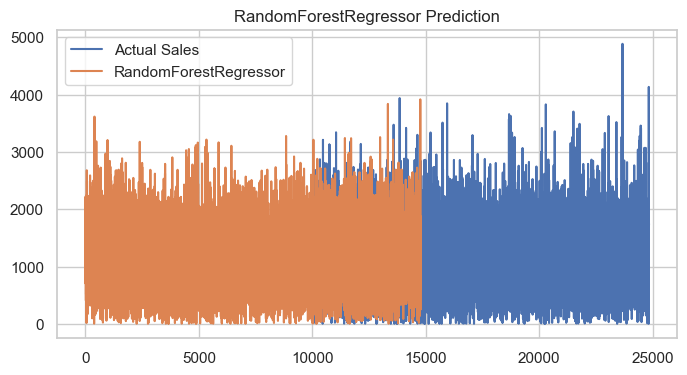

In [69]:

plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(forest_pred, label='RandomForestRegressor')
plt.legend(loc='best')
plt.title('RandomForestRegressor Prediction')
plt.show()

In [71]:
mse = mean_squared_error(y_test, forest_pred)
msle = mean_squared_log_error(y_test, forest_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)
# Append the results to the DataFrame
results = pd.DataFrame([['Random Forest', mse, msle, rmse, rmsle]],
 columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results


,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,34302.19181,0.035711,185.21,0.18897


In [72]:

import xgboost as xgb
# Initialize and fit the XGBoost model
xgboost = xgb.XGBRegressor()
model_xgboost = xgboost.fit(X_train, y_train)
# Make predictions on X_test
xgboost_pred = model_xgboost.predict(X_test)
# Append the results to the DataFrame
mse = mean_squared_error(y_test, xgboost_pred)
# msle = mean_squared_log_error(y_test, xgboost_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)
model_results = pd.DataFrame([['XGBoost', mse, msle, rmse, rmsle]],
 columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)
results


,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,34302.191810,0.035711,185.21,0.18897
1,XGBoost,27111.111766,0.035711,164.65,0.18897


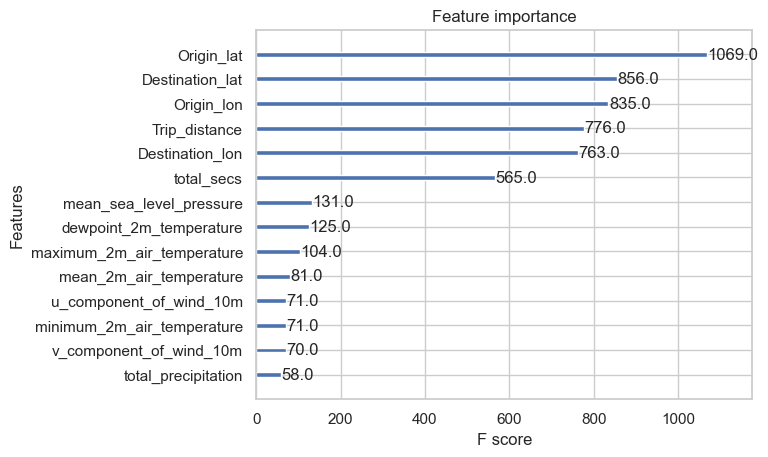

Origin_lat: 1069.0
Destination_lat: 856.0
Origin_lon: 835.0
Trip_distance: 776.0
Destination_lon: 763.0
total_secs: 565.0
mean_sea_level_pressure: 131.0
dewpoint_2m_temperature: 125.0
maximum_2m_air_temperature: 104.0
mean_2m_air_temperature: 81.0
minimum_2m_air_temperature: 71.0
u_component_of_wind_10m: 71.0
v_component_of_wind_10m: 70.0
total_precipitation: 58.0


In [74]:

import matplotlib.pyplot as plt
# Using plot_importance function to visualize feature importance
xgb.plot_importance(model_xgboost)
plt.show()
# Alternatively, you can use the get_booster() method to get the booster object
booster = model_xgboost.get_booster()
# Get the feature importance scores
importance_scores = booster.get_score(importance_type='weight')
# Sort the importance scores in descending order
sorted_importance_scores = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
# Print the sorted importance scores
for feature, score in sorted_importance_scores:
 print(f"{feature}: {score}")

# Models Comparison


In [75]:
results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,34302.191810,0.035711,185.21,0.18897
1,XGBoost,27111.111766,0.035711,164.65,0.18897


# Model Evaluation (eval_set)


In [76]:
# Split data into parts
x_eval = eval_set.drop(['ETA'], axis = 1)
y_eval = eval_set['ETA']

In [77]:
xgboost_pred_eval = model_xgboost.predict(x_eval)
mse = mean_squared_error(y_eval, xgboost_pred_eval)

In [78]:
rmse = np.sqrt(mse).round(2)
rmse

152.38

Predicting sales in Our test

In [79]:

test_pred = model_xgboost.predict(test)
test_pred


array([1483.9465 ,  816.3853 , 1033.9655 , ...,  634.02454, 1228.1067 ,
        592.4595 ], dtype=float32)

In [80]:

test_copy['ETA'] = test_pred
sub = test_copy[['ID', 'ETA']]
sub

,ID,ETA
0,000V4BQX,1483.946533
1,003WBC5J,816.385315
2,004O4X3A,1033.965454
3,006CEI5B,1824.710571
4,009G0M2T,670.283569
...,...,...
35620,ZZXSJW3Q,408.054016
35621,ZZYPNYYY,1153.029053
35622,ZZYVPKXY,634.024536
35623,ZZZXGRIO,1228.106689


In [82]:
 #Save sample submission
sub.to_csv('submission.csv')

In [85]:

with open('scaler.pkl', 'wb') as f:
 pickle.dump(scaler, f)
with open('model.pkl', 'wb') as f:
 pickle.dump(model_xgboost, f)
